autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=100, bias=True)
    (3): ReLU()
    (4): Linear(in_features=100, out_features=10, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=10, out_features=100, bias=True)
    (1): Linear(in_features=100, out_features=100, bias=True)
    (2): ReLU()
    (3): Linear(in_features=100, out_features=784, bias=True)
    (4): ReLU()
  )
)
Epoch0/9
Epoch loss:0.001338
Epoch complete in 0m7s
-------------------------
Epoch1/9
Epoch loss:0.000588
Epoch complete in 0m8s
-------------------------
Epoch2/9
Epoch loss:0.000485
Epoch complete in 0m7s
-------------------------
Epoch3/9
Epoch loss:0.000449
Epoch complete in 0m6s
-------------------------
Epoch4/9
Epoch loss:0.000421
Epoch complete in 0m7s
-------------------------
Epoch5/9
Epoch loss:0.000408
Epoch complete in 0m7s
-------------------------
Epoch6/9
Epoch loss:0.000

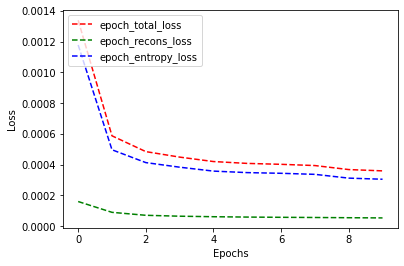

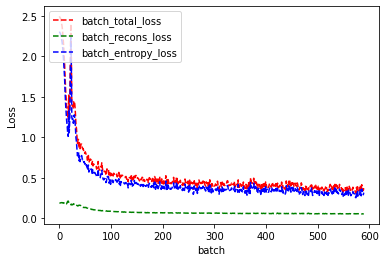

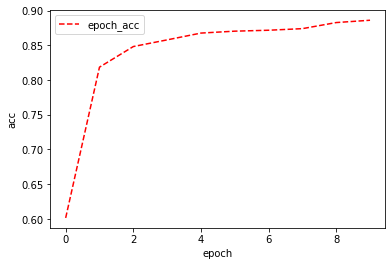

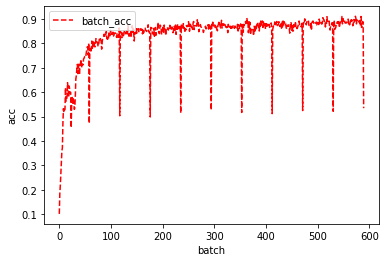

In [50]:
%matplotlib inline
import torch
#torch.manual_seed(2)# 这个地方我没又看懂,为什么会出现nan---->因为学习率过大
#torch.manual_seed(2)
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms
import numpy as np
from PIL import Image
import copy
import time
import ipdb

trainLoader=torch.utils.data.DataLoader(datasets.FashionMNIST('./fmnist/',train=True,
                                                             download=True,
                                                             transform=transforms.Compose(
                                                                 [transforms.ToTensor()])),batch_size
                                       =1024,shuffle=True,num_workers=1)
#可以看到这里的batch_size=1024
testLoader=torch.utils.data.DataLoader(datasets.FashionMNIST('./fmnist/',train=False,
                                                             download=True,
                                                             transform=transforms.Compose(
                                                                 [transforms.ToTensor()])),batch_size
                                       =1024,shuffle=True,num_workers=1)
#对于这个数据集

class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder,self).__init__()
        self.encoder=nn.Sequential(
            nn.Linear(28*28,100),
            nn.ReLU(),
            nn.Linear(100,100),
            nn.ReLU(),#将结构继续划分，并不是一直所谓的层的累加，而是分成了encoder和decoder
            nn.Linear(100,10))
        self.decoder=nn.Sequential(
            nn.Linear(10,100),
            nn.Linear(100,100),
            nn.ReLU(),
            nn.Linear(100,28*28),
            nn.ReLU())
    
    def forward(self,x):
        x1=self.encoder(x)
        out=self.decoder(x1)
        return x1,out
net=autoencoder()
print(net)

# Definining the training routine

use_gpu=torch.cuda.is_available()
labda=1;
def train_model(model,optimizer,num_epochs):
    start=time.time()
    epoch_total_loss=[]
    epoch_recons_loss=[]
    epoch_entropy_loss=[]
    epoch_acc=[]#list for saving the accuracy per epoch
    
    batch_total_loss=[]
    batch_recons_loss=[]
    batch_entropy_loss=[]
    batch_acc=[]
    
    cnt=0;
    criter1=nn.MSELoss()
    criter2=nn.CrossEntropyLoss()
    for epoch in range(num_epochs):
        
        epochStartTime=time.time()
        print('Epoch{}/{}'.format(epoch,num_epochs-1))#因为epoch是从0开始的，所以num_epochs需要减去1
        #假如num_epochs=5,最终显示的是0/4,1/4,2/4,3/4,4/4
        
        temp_loss=0.0
        temp_mse_loss=0.0
        temp_entropy_loss=0.0
        temp_corrects=0.0
        
        #loading data in batches
        batch=0
        for data in trainLoader:
            inputs,labels=data #每次产生1024个样本
            if use_gpu:
                inputs,labels=Variable(inputs.view(inputs.size(0),-1).cuda()),
                Variable(labels.cuda())
            else:
                inputs,labels=Variable(inputs.view(inputs.size(0),-1)),Variable(labels)
            #labels的影响不大，主要是inputs的取值
            #Initializing model gradients to zero
            model.zero_grad()
            #Data feed-forawrd through the network
            decode,outputs=model(inputs)
            
            #Finding the MSE
            #criterion=F.mse_loss()
            mse_loss=criter1(outputs,inputs)
            entropy_loss=criter2(decode,labels)
            loss=mse_loss+labda*entropy_loss
            #Backpropagating the loss and updating the model
            _,preds=torch.max(decode.data,1)
            correct=torch.sum(preds==labels.data)
            
            loss.backward()
            optimizer.step()
            
            #Accumulating the loss for each batch
            temp_loss+=loss.data.item()
            temp_mse_loss+=mse_loss.data.item()
            temp_entropy_loss+=entropy_loss.data.item()
            temp_corrects+=correct
            
            batch_total_loss.append(loss.data.item())
            batch_recons_loss.append(mse_loss.data.item())
            batch_entropy_loss.append(entropy_loss.data.item())
            
            #ipdb.set_trace()
            batch_acc.append(correct/1024.0)

            cnt+=1
        epoch_loss=temp_loss/60000#Total loss for one epoch
        epoch_total_loss.append(epoch_loss)
        
        acc=float(temp_corrects)/60000.0 #总共的预测正确的样本
        epoch_acc.append(acc)#saving
        
        epoch_recons_loss.append(temp_mse_loss/60000.0)
        
        epoch_entropy_loss.append(temp_entropy_loss/60000.0)
        
        print("Epoch loss:{:.6f}".format(epoch_loss))
        epochTimeEnd=time.time()-epochStartTime
        print('Epoch complete in {:.0f}m{:.0f}s'.format(epochTimeEnd//60,epochTimeEnd%60))
        print('-'*25)
        #plotting Loss vs Epochs
        
    print("总的迭代次数={}".format(cnt))    
    time_elapsed=time.time()-start
    print('Training commplete in {:.0f}m{:.0f}'.format(time_elapsed//60,time_elapsed%60))
    
    #画epoch的loss
    fig1=plt.figure(1)
    plt.plot(range(num_epochs),epoch_total_loss,'r--',label='epoch_total_loss')
    plt.plot(range(num_epochs),epoch_recons_loss,'g--',label='epoch_recons_loss')
    plt.plot(range(num_epochs),epoch_entropy_loss,'b--',label='epoch_entropy_loss')
    plt.legend(loc='upper left')
    plt.xlabel('Epochs')
    plt.ylabel("Loss")
    fig1.savefig("epoch.png")

    fig1=plt.figure(2)
    plt.plot(range(cnt),batch_total_loss,'r--',label='batch_total_loss')
    plt.plot(range(cnt),batch_recons_loss,'g--',label='batch_recons_loss')
    plt.plot(range(cnt),batch_entropy_loss,'b--',label='batch_entropy_loss')
    plt.legend(loc='upper left')
    plt.xlabel('batch')
    plt.ylabel("Loss")
    fig1.savefig("batch.png")

    fig1=plt.figure(3)
    plt.plot(range(num_epochs),epoch_acc,'r--',label='epoch_acc')
    plt.legend(loc='upper left')
    plt.xlabel('epoch')
    plt.ylabel("acc")
    fig1.savefig("epoch_acc.png")

    fig1=plt.figure(4)
    plt.plot(range(cnt),batch_acc,'r--',label='batch_acc')
    plt.legend(loc='upper left')
    plt.xlabel('batch')
    plt.ylabel("acc")
    fig1.savefig("batch_acc.png")
    return model

optimizer=optim.SGD(net.parameters(),lr=0.1,momentum=0.9)
net=train_model(net,optimizer,num_epochs=10)#每次不能单独运行这个

# 测试集重构的效果

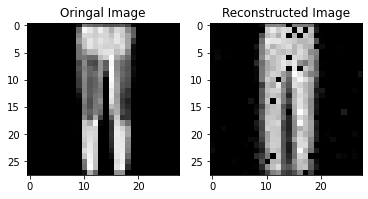

In [51]:
net.eval()
TestImg=testLoader.dataset[3][0]
if use_gpu:
    outputImg=net(Variable(TestImg.view(TestImg.size(0),-1)).cuda())#预测的时候需要将它转化成Variable类型，才能预测
else:
    encodeImg,outputImg=net(Variable(TestImg.view(TestImg.size(0),-1)))

outputImg=outputImg.data.view(-1,28,28).cpu()

fig=plt.figure()
plot=fig.add_subplot(1,2,1)
img=np.array(TestImg.numpy())[0]
plot.set_title("Oringal Image")
imgplot=plt.imshow(img,cmap="gray")

plot=fig.add_subplot(1,2,2)
img=np.array(outputImg.numpy())[0]
plot.set_title("Reconstructed Image")
imgplot=plt.imshow(img,cmap="gray")
plt.show()

# 可以这个总的效果还是可以的

# 测试集上的分类效果

In [52]:
# testData=testLoader.dataset
# print(type(testData))
# print(len(testData))
# print(testData)
# #print(testData[0])
# print(type(testData[0]))#还是一个元组
# print(len(testData[0]))#还是一个元组
# print(testData[0][0].shape)#(1,28,28)
# print(testData[0][1])#是一个整形值，没有shape属性

# Finding testing accuracy
test_running_corr=0
#loading data in batches
batches=0
runing_corrects=0.0
for tsData in testLoader:
    inputs,labels=tsData
    #ipdb.set_trace()
    #wrap them in Variable
    if use_gpu:
        inputs,labels=Variable(inputs.view(inputs.size(0),-1).cuda()),Variable(labels.cuda())
    else:
        inputs,labels=Variable(inputs.view(inputs.size(0),-1)),Variable(labels)
    #Feedforwarded train data batch through model
    output,_=net(inputs)
    _,preds=output.data.max(1)
    runing_corrects+=torch.sum(preds==labels.data)

#Finding total number of correct predictions
ts_acc=runing_corrects/10000.0
print("Accuracy on test set="+str(ts_acc))#测试集集上的准确率达到了87.18%总的来说还可以吧

Accuracy on test set=tensor(0.8658)
